### Imports

In [5]:
import os
import sys
import pandas as pd 
import numpy as np 
import pyarrow.parquet as pq
from pathlib import Path
from random import sample
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#make more rows and columns visible in the output console
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', 1000)
np.set_printoptions(threshold=sys.maxsize)

In [147]:
!pip install dtw-python
from dtw import *
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\Users\paseckat\AppData\Local\Continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


### Load the Data

In [13]:
full_df = pd.read_csv('csv_file_udacity.csv',dtype =  {'retail_prod_id': np.int32})

In [14]:
full_df.head()

,date,zrep,retail_prod_id,description,retailer,retail_store_id,retail_store_name,sales_value,sales_qty,brand,sub_brand,weight,tier
0,2019-08-13,1,11400020,130,0,1022,1455,24.0,24.0,3,21,500.0,1
1,2019-08-13,1,11400020,130,0,1023,364,28.0,28.0,3,21,500.0,1
2,2019-08-13,1,11400020,130,0,1024,432,34.0,34.0,3,21,500.0,1
3,2019-08-13,1,11400020,130,0,1025,844,84.0,84.0,3,21,500.0,1
4,2019-08-13,1,11400020,130,0,1026,2454,44.0,44.0,3,21,500.0,1


### Introduction to the dataset

This is a sales dataset that has been provided as to me as a sensitive commercial dataset and hence has been anonymized prior to loading into this project workbook, all the numeric values ('retail_prod_id', 'sales_value', 'sales_qty', 'weight') have been changes, as well as categorical columns (('zrep', 'description', 'retailer', 'retail_store_id', 'retail_store_name', 'brand', 'sub_brand', 'tier') have been re-coded into numerical values, hence we will be refering to these newly coded values when speaking about retailers etc.

This dataset is  a set of time series for sales quantity, weight and and value recorded every day by zrep(item), description(item level) ,retailer, store name + id (several stores per retailer),  brand and sub-brand.

It might be useful to explain some of the granularity level relationship of this dataset :
* A combination of item (zrep) and Store, i s the most granular level of the data (retail_prod_id)
* zrep(item) and its description can span across several retail_prod_id as zrep is store and retailer agnostic, but not retail_prod_id
* Sub brand and Brand span across multiple stores
* Brand of course has multiple items and even more retail_prod_ids
* A retailer has multiple retail_prod_id, zreps, sub-brands, brands and so on.


### Clustering time series

In this analysis we will be using clustering in order to try and group the items that have similar structure , which allows us to be prepared to handle items in same groups in a similar way in the future, if fpr example,  we will have a business request to allocate a new product into a "category" of already existing products to see how it will behave. 

### Basic information about the dataset

Let's see how large the dataset it and get some basic statistics to get to know it better

In [15]:
# How large is our dataset
full_df.shape

(17573559, 13)

In [16]:
# It is a rather large one, what are the dattypes?
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17573559 entries, 0 to 17573558
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   date               object 
 1   zrep               int64  
 2   retail_prod_id     int32  
 3   description        int64  
 4   retailer           int64  
 5   retail_store_id    int64  
 6   retail_store_name  int64  
 7   sales_value        float64
 8   sales_qty          float64
 9   brand              int64  
 10  sub_brand          int64  
 11  weight             float64
 12  tier               int64  
dtypes: float64(3), int32(1), int64(8), object(1)
memory usage: 1.6+ GB


Most of the columns are  numeric, but the memory usage of the dataset is rather impressive, 
we will need to trim it down to only the columns that we need to work with. First let's have a look at the basic stats to see if there is anythinng out of norm

In [17]:
full_df.describe()

,zrep,retail_prod_id,description,retailer,retail_store_id,retail_store_name,sales_value,sales_qty,brand,sub_brand,weight,tier
count,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07,1.757356e+07
mean,4.955613e+01,8.310125e+07,1.008960e+02,2.020457e+00,1.371394e+03,1.638760e+03,1.435904e+01,1.101355e+01,1.706559e+00,1.586687e+01,7.566562e+02,1.253754e+00
std,4.382750e+01,5.052403e+07,4.171944e+01,1.406203e+00,8.489252e+02,9.643761e+02,1.462293e+02,1.207620e+02,1.485710e+00,9.522981e+00,3.332827e+02,1.088059e+00
min,1.000000e+00,1.025400e+04,3.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.784000e+02,-9.000000e+01,0.000000e+00,2.000000e+00,3.000000e+02,0.000000e+00
25%,1.300000e+01,1.152673e+07,5.800000e+01,0.000000e+00,6.870000e+02,7.890000e+02,4.000000e+00,2.000000e+00,0.000000e+00,4.000000e+00,5.000000e+02,0.000000e+00
50%,4.700000e+01,1.050859e+08,1.210000e+02,3.000000e+00,1.305000e+03,1.608000e+03,7.400000e+00,6.000000e+00,3.000000e+00,2.100000e+01,5.000000e+02,1.000000e+00
75%,7.800000e+01,1.131881e+08,1.320000e+02,3.000000e+00,1.973000e+03,2.496000e+03,1.400000e+01,1.000000e+01,3.000000e+00,2.400000e+01,1.000000e+03,2.000000e+00
max,1.880000e+02,1.734632e+08,1.920000e+02,4.000000e+00,3.194000e+03,3.308000e+03,3.921400e+04,3.867200e+04,3.000000e+00,2.700000e+01,1.500000e+03,3.000000e+00


This is quite odd that we see negative value as minimum value os sales_qty and sales_value. Let's investigate how many are there and what can we do about them

In [20]:
full_df[full_df['sales_qty'] < 0].shape

(2638, 13)

For the purpose of this analysis we shall get rid of these values, as sometimes , in the business context , transactions with negative sales valuee might mean that a certain correction was being made, or a reversal of an earlier transaction, but as we do not really have a context here we will omit these records. In the real life business situation we should always investigate these where possible and decided what to do with them. Sometimes it might be an option to convert these to '0', but only if the context allows.

In [29]:
full_df = full_df[full_df['sales_qty']>=  0]

In [30]:
full_df.shape

(17570921, 13)

A quick check for nulls

In [89]:
full_df.isna().sum()

date                 0
zrep                 0
retail_prod_id       0
description          0
retailer             0
retail_store_id      0
retail_store_name    0
sales_value          0
sales_qty            0
brand                0
sub_brand            0
weight               0
tier                 0
dtype: int64

As a final quick check, let's explore the a little more around levels of granularity of this dataset and how it is structured before we move to pre-processing

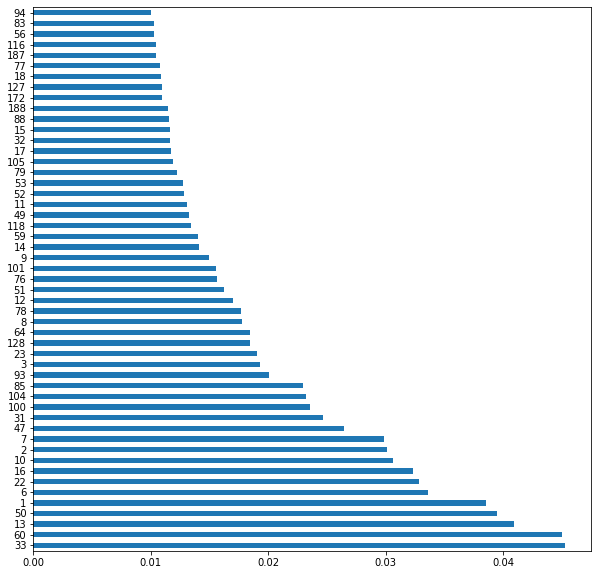

In [38]:
fig = plt.figure(figsize=(10,10))
full_df.zrep.value_counts(normalize=True).plot(kind='barh')

In [67]:
full_df.retailer.value_counts(normalize=True)

3    0.672918
0    0.325916
1    0.000784
2    0.000279
4    0.000102
Name: retailer, dtype: float64

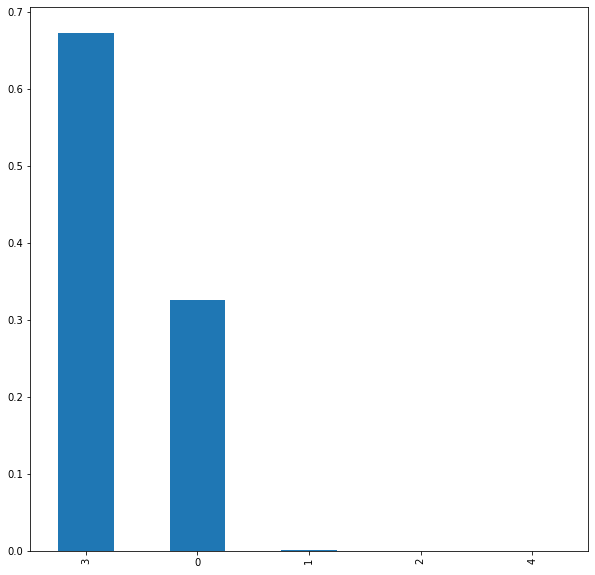

In [65]:
fig = plt.figure(figsize=(10,10))
plt.xticks(np.arange(min(full_df.retailer.value_counts(normalize=True)), max(full_df.retailer.value_counts(normalize=True))))
full_df.retailer.value_counts(normalize=True).plot(kind='bar')

We see quite well distributed zreps but the retailers are very heavily skewed towards retailer number 3 and 0 , with retailers 1 2 and 4 , representing less than 1 % oif cases altogether. This might be an issue when we will be trying to form the clusters later, if we use retailers to cluster our items. 

### Pre- processing

Now that we had a very brief introduction to the dataset, let's select the columns that we will be working with. It could be a good idea to cluster using sales_qty rather than anything else, as it represents a demand from retailer/store quite well.

In [69]:
df = full_df[['date','zrep','retail_prod_id','retailer','retail_store_id','sales_qty','brand','sub_brand']]

Let's create a combined identifier of zrep and retailer to see if we can work with clustering that into meaningful groups

In [70]:
item_retail_id = df['zrep'].astype(str)+'_'+df['retailer'].astype(str)
df.insert(loc=0, column='item_retail_id', value=item_retail_id)

In [74]:
#Only leaving the necessary columns for the analysis and unstacking the column to bring it to the wide format 
#that will be more convinient for the analysis

In [73]:
df_new = df[['item_retail_id','date','zrep','retailer','sales_qty']]

In [75]:
df_unstacked = df_new.pivot_table(index=['zrep','item_retail_id','retailer'], columns=['date'],
                                  aggfunc=np.sum, fill_value=0)


Now we have the desired format, let's change the dates column names to numerical values for the ease of transformations later on and for more readibility

In [76]:
df_unstacked.head(3)

sales_qty                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               \
date                         2019-08-13 2019-08-14 2019-08-15 2019-08-16 2019-08-17 2019-08-18 2019-08-19 2019-08-20 2019-08-21 2019-08-22 2019-08-23 2019-08-24 2019-08-25 2019-08-26 2019-08-27 2019-08-28 2019-08-29 2019-08-30 2019-08-31 2019-09-01 2019-09-02 2019-09-03 2019-09-04 2019-09-05 2019-09-06 2019-09-07 2019-09-08 2019-09-09 2019-09-10 2019-09-11 2019-09-12 2019-09-13 2019-09-14 2019-09-15 2019-09-16 2019-09-17 2019-09-18 2019-09-19 2019-09-20 2019-09-21 2019-09-22 2019-09-23 2019-09-24 2019-09-25 2019-09-26 2019-09-27 2019-09-28 2019-09-29 2019-09-30 2019-10-01 2019-10-02 2019-10-03 2019-10-04 2019-10-05 2019-10-06 2019-10-07 2019-10-08 2019-10-09 2019-10-10 2019-10-11 2019-10-12 2019-10-13 2019-10-14 2019-10-15 2019-10-16 2019-10-17 2019-10-18 2019-10-19 2019-10-20 2019-10-21 2019-10-22 2019-10-23 2019-10-24 2019-10-25 2019-10-26 2019-10-27 2019-10-28 2019-10-29 2019-10-30 2019-10-31 2019-11-01 2019-11-02 2019-11-03 2019-11-04 2019-11-05 2019-11-06 2019-11-07 2019-11-08   
zrep item_retail_id retailer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1    1_0            0             13274      12712      13650      16288      15086      10864      13492      10964      11810      14532      15656      14268       8464      11646      13650      12554      13190      16222      17508      13106      15766      13338      11940      12906      15414      16682      12444      14438      12044      11382      12008      15416      16202      12748      15082      12852      11548      11090      13264      13824      11656      12010       9924       9562      10648      13362      11488      11706      14306      11784      11990      14222      17820      19346      15146      17522      13974      13156      14492      18292      19328      14128      16128      13324      11894      13704      17890      18208      14512      17856      14092      13352      14674      19040      20320      15036      17674      14696      13218      14104      18274      18208      14018      16686      13138      12288      13066      16690   
     1_1            1         

In [78]:
df_unstacked.reset_index(drop=False, inplace=True)
df_unstacked.columns = df_unstacked.columns.droplevel(1)
new_cols = []
for i in range(df_unstacked.shape[1] -3):
    new_cols.append(i)
new_cols = np.array(new_cols).astype('str')
df_unstacked.columns.values[3:] = new_cols

In [79]:
#look at single zrep rows to get an appreciation for the dataset structure
df_unstacked.loc[df_unstacked.zrep == 1].sort_values("item_retail_id").head()

,zrep,item_retail_id,retailer,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
0,1,1_0,0,13274,12712,13650,16288,15086,10864,13492,10964,11810,14532,15656,14268,8464,11646,13650,12554,13190,16222,17508,13106,15766,13338,11940,12906,15414,16682,12444,14438,12044,11382,12008,15416,16202,12748,15082,12852,11548,11090,13264,13824,11656,12010,9924,9562,10648,13362,11488,11706,14306,11784,11990,14222,17820,19346,15146,17522,13974,13156,14492,18292,19328,14128,16128,13324,11894,13704,17890,18208,14512,17856,14092,13352,14674,19040,20320,15036,17674,14696,13218,14104,18274,18208,14018,16686,13138,12288,13066,16690,18814,13974,16674,13382,12474,12514,14908,16780,12702,14418,12194,11302,11864,14658,15332,11398,13962,11462,10460,11780,14008,15684,12324,14244,11586,10770,11456,13778,14436,11548,13422,11838,11390,10894,12754,14058,11092,13050,11252,10206,11448,13972,14896,11152,17358,5346,12,3122,11032,12308,8562,14744,10790,3790,14690,17684,19496,15408,16540,15066,14046,13976,18048,20536,15980,15822,13596,12848,14172,18296,19508,15950,16722,13390,12652,14480,18598,21190,16210,17480,14304,13166,14250,18856,20606,16512,17234,14270,12494,14328,17838,20066,13782,16562,13802,12252,12020,13812,16082,11344,13260,10750,9974,10688,14512,16040,11300,13258,11128,10010,11326,16302,19084,12902,14686,12688,12616,14894,18156,19730,14040,17698,15840,19006,34748,41520,49300,34608,48780,45122,56372,78432,48738,36060,15974,31116,25022,25628,24514,28974,26472,15950,25300,25112,25620,26922,30412,26984,15386,26216,24132,25996,30640,27942,24858,2608,21756,26206,25958,27204,26446,23504,14184,22404,22086,22198,24256,25874,23558,14648,22884,21892,22494,25302,26830,24732,14994,23474,22442,22962,25472,22350,20204,15056,21380,20084,20198,20536,22928,20900,12960,20610,18384,16292,19556,24444,21694,12566,14100,17432,15836,17422,19402,18562,12196,17292,15876,17406,21304,24016,23138,14636,20580,18514,18642,21160,22278,20002,12108,17344,15670,14902,17392,20420,19052
1,1,1_1,1,1876,1774,1700,1550,1346,1184,1520,1486,3786,3438,3052,2718,2148,3212,3864,3880,3692,3506,3138,2816,4312,4346,4390,4450,3652,3394,3080,4630,2850,1580,1502,1322,970,968,1440,1300,1242,1156,1130,818,832,1312,1294,1364,1136,960,1026,862,1340,1694,5376,5428,5024,4282,3766,5894,5710,5438,5342,4440,4144,3762,5358,5422,5280,4850,4350,3966,3606,5254,3190,1294,1152,1036,914,828,1354,1196,1154,924,980,990,770,1236,1226,1182,1252,988,930,768,1236,1540,4556,4290,3726,3626,3098,4740,4740,4764,4228,3564,3266,2982,4572,4708,4558,4206,3398,3436,3046,4838,2754,1328,1332,986,1010,876,1328,1102,1196,1122,912,868,780,1162,998,970,928,894,764,758,1096,802,0,610,1124,2088,1990,2786,2432,1900,3544,3550,3422,2908,4322,4402,4698,4638,3956,3446,2982,4288,4146,4438,4506,3802,3626,3132,4416,4488,4080,3914,3422,3126,3038,4372,4100,3848,3744,3296,3088,2918,4268,2834,1552,1394,1162,1174,944,1562,1318,1318,1226,1006,1064,942,1338,1328,1194,1196,1084,1066,884,1

In [29]:
#df_unstacked[['zrep','item_retail_id','retailer']] = df_unstacked[['zrep','item_retail_id','retailer']].astype(str)

In [81]:
#checking the dataset looks right and the shape is accurate

In [80]:
df_unstacked.head(3)

,zrep,item_retail_id,retailer,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
0,1,1_0,0,13274,12712,13650,16288,15086,10864,13492,10964,11810,14532,15656,14268,8464,11646,13650,12554,13190,16222,17508,13106,15766,13338,11940,12906,15414,16682,12444,14438,12044,11382,12008,15416,16202,12748,15082,12852,11548,11090,13264,13824,11656,12010,9924,9562,10648,13362,11488,11706,14306,11784,11990,14222,17820,19346,15146,17522,13974,13156,14492,18292,19328,14128,16128,13324,11894,13704,17890,18208,14512,17856,14092,13352,14674,19040,20320,15036,17674,14696,13218,14104,18274,18208,14018,16686,13138,12288,13066,16690,18814,13974,16674,13382,12474,12514,14908,16780,12702,14418,12194,11302,11864,14658,15332,11398,13962,11462,10460,11780,14008,15684,12324,14244,11586,10770,11456,13778,14436,11548,13422,11838,11390,10894,12754,14058,11092,13050,11252,10206,11448,13972,14896,11152,17358,5346,12,3122,11032,12308,8562,14744,10790,3790,14690,17684,19496,15408,16540,15066,14046,13976,18048,20536,15980,15822,13596,12848,14172,18296,19508,15950,16722,13390,12652,14480,18598,21190,16210,17480,14304,13166,14250,18856,20606,16512,17234,14270,12494,14328,17838,20066,13782,16562,13802,12252,12020,13812,16082,11344,13260,10750,9974,10688,14512,16040,11300,13258,11128,10010,11326,16302,19084,12902,14686,12688,12616,14894,18156,19730,14040,17698,15840,19006,34748,41520,49300,34608,48780,45122,56372,78432,48738,36060,15974,31116,25022,25628,24514,28974,26472,15950,25300,25112,25620,26922,30412,26984,15386,26216,24132,25996,30640,27942,24858,2608,21756,26206,25958,27204,26446,23504,14184,22404,22086,22198,24256,25874,23558,14648,22884,21892,22494,25302,26830,24732,14994,23474,22442,22962,25472,22350,20204,15056,21380,20084,20198,20536,22928,20900,12960,20610,18384,16292,19556,24444,21694,12566,14100,17432,15836,17422,19402,18562,12196,17292,15876,17406,21304,24016,23138,14636,20580,18514,18642,21160,22278,20002,12108,17344,15670,14902,17392,20420,19052
1,1,1_1,1,1876,1774,1700,1550,1346,1184,1520,1486,3786,3438,3052,2718,2148,3212,3864,3880,3692,3506,3138,2816,4312,4346,4390,4450,3652,3394,3080,4630,2850,1580,1502,1322,970,968,1440,1300,1242,1156,1130,818,832,1312,1294,1364,1136,960,1026,862,1340,1694,5376,5428,5024,4282,3766,5894,5710,5438,5342,4440,4144,3762,5358,5422,5280,4850,4350,3966,3606,5254,3190,1294,1152,1036,914,828,1354,1196,1154,924,980,990,770,1236,1226,1182,1252,988,930,768,1236,1540,4556,4290,3726,3626,3098,4740,4740,4764,4228,3564,3266,2982,4572,4708,4558,4206,3398,3436,3046,4838,2754,1328,1332,986,1010,876,1328,1102,1196,1122,912,868,780,1162,998,970,928,894,764,758,1096,802,0,610,1124,2088,1990,2786,2432,1900,3544,3550,3422,2908,4322,4402,4698,4638,3956,3446,2982,4288,4146,4438,4506,3802,3626,3132,4416,4488,4080,3914,3422,3126,3038,4372,4100,3848,3744,3296,3088,2918,4268,2834,1552,1394,1162,1174,944,1562,1318,1318,1226,1006,1064,942,1338,1328,1194,1196,1084,1066,884,1

In [82]:
df_unstacked.shape

(221, 316)

In [84]:
#check if this is consistent with the original dataset
full_df.date.nunique()

313

In [86]:
#number of dates is in line with 316 - 3 columns of df_unstacked, now let's check if zreps are all there
df.item_retail_id.nunique()

221

In [90]:
#221 is the number of rows in df_unstacked, so that matches the original df

In [91]:
# Now let's check for nulls that might have appeared after we unstacked the dataframe into the current format
df_unstacked.isnull().sum()

zrep              0
item_retail_id    0
retailer          0
0                 0
1                 0
2                 0
3                 0
4                 0
5                 0
6                 0
7                 0
8                 0
9                 0
10                0
11                0
12                0
13                0
14                0
15                0
16                0
17                0
18                0
19                0
20                0
21                0
22                0
23                0
24                0
25                0
26                0
27                0
28                0
29                0
30                0
31                0
32                0
33                0
34                0
35                0
36                0
37                0
38                0
39                0
40                0
41                0
42                0
43                0
44                0
45                0
46                0


### Exploration of time series

Let's plot the timeseries on different levels of granurality to examine them visually as a first step

In [92]:
series = df_unstacked.iloc[:,3:].columns.tolist()

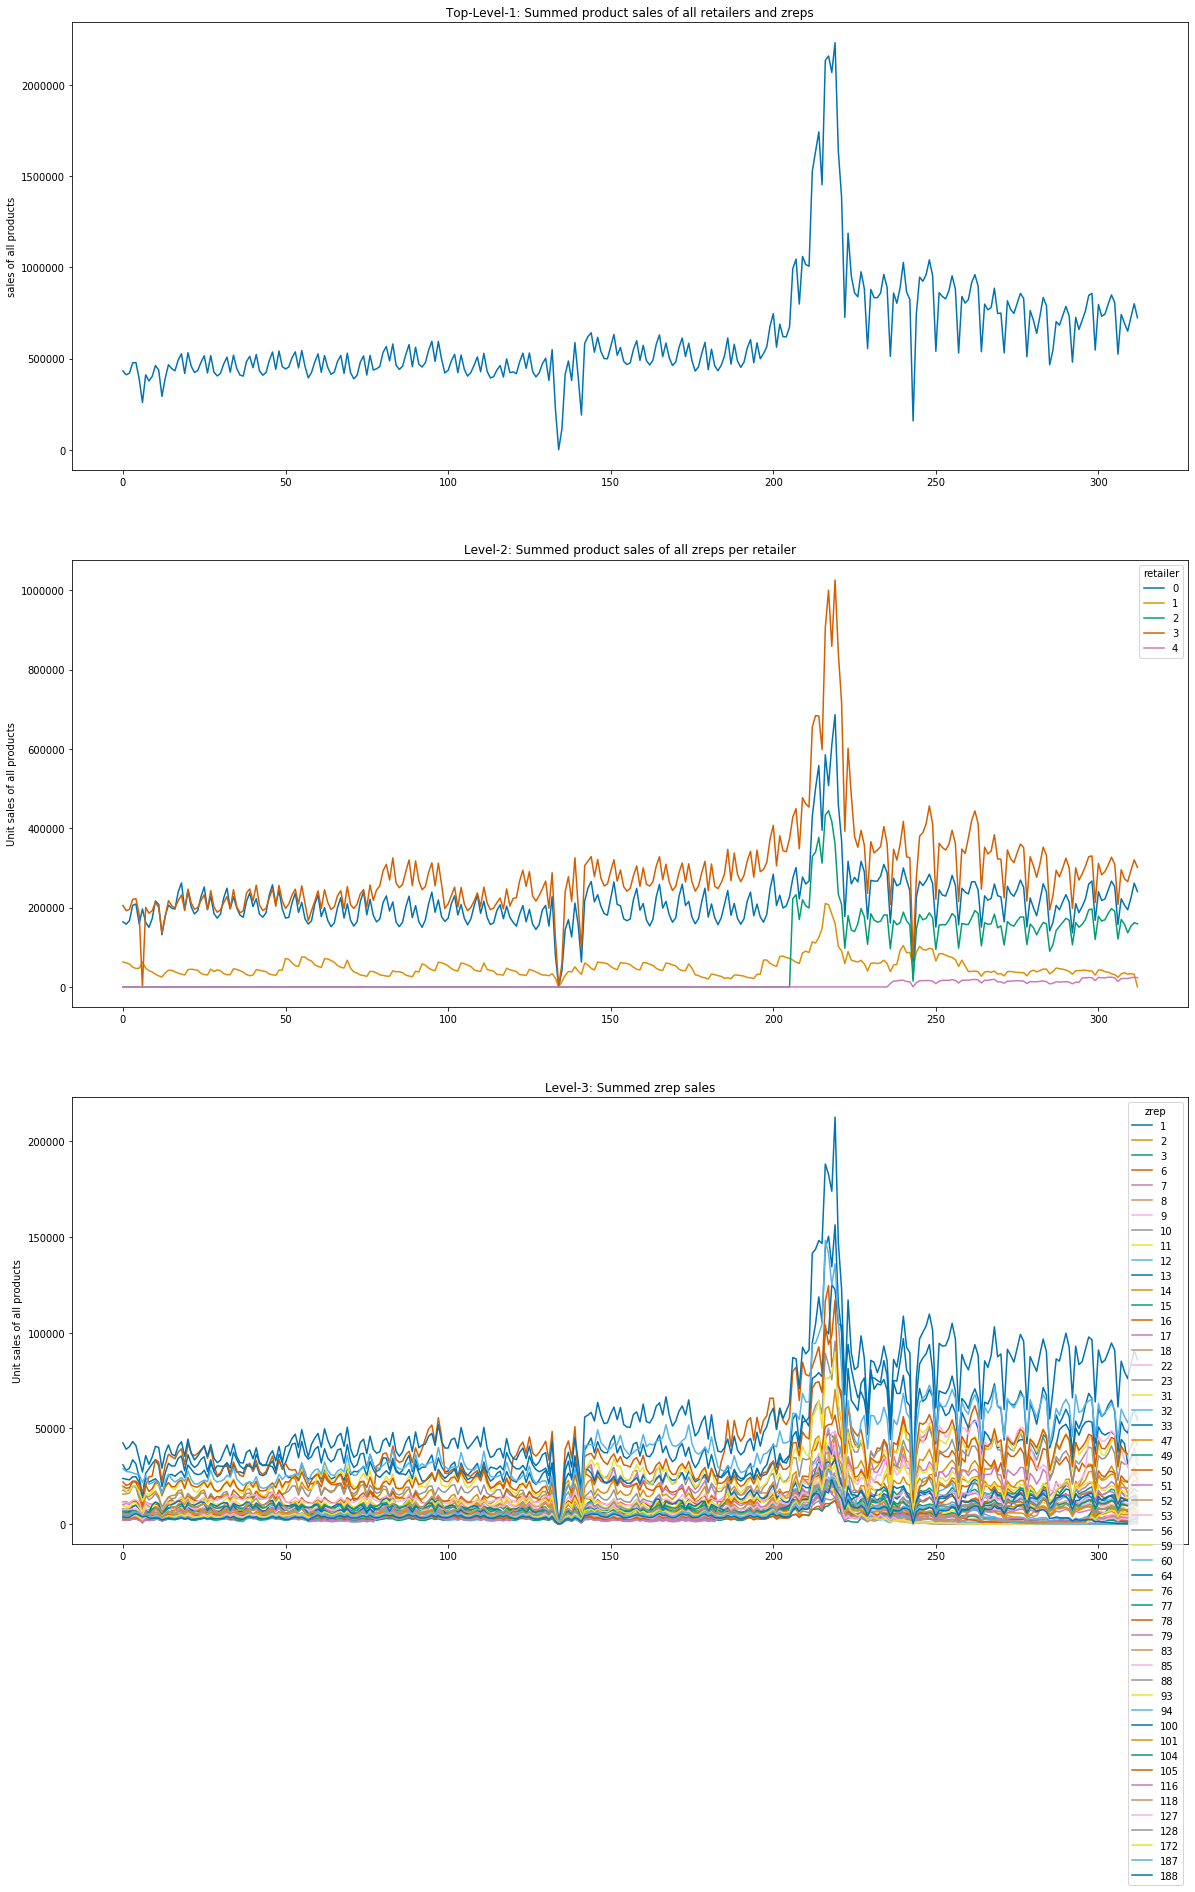

In [93]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(3,1,figsize=(20,28))

df_unstacked[series].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all retailers and zreps")
ax[0].set_ylabel("sales of all products");

df_unstacked.groupby("retailer")[series].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all zreps per retailer");
ax[1].set_ylabel("Unit sales of all products");

df_unstacked.groupby("zrep")[series].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed zrep sales")
ax[2].set_ylabel("Unit sales of all products");
# df_unstacked.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
# ax[3].set_title("Level-4: Summed product sales per category")
# ax[3].set_ylabel("Unit sales of all products");
# df_unstacked.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
# ax[4].set_title("Level-4: Summed product sales per product department")
# ax[4].set_ylabel("Unit sales of all products");

* We see that there are periodic patterns in these series and it is also more visually clear now how these aggregation levels work in the dataset as they also follow the same shape of the series on all 3 levels.
* It is also interesting to iobserve that around days 215-220 we see a massive upwards spike in the series for all of the zreps and retailers. Let's have a look where these days fall in the calendar

In [95]:
startdate = '2019-08-13'
pd.to_datetime(startdate) + pd.DateOffset(days=220)

Timestamp('2020-03-20 00:00:00')

Most likely, What we see in the graphs is a clear demonstration of the effect of Covid 19 on the sales of this business to it's retailers as March is around the time where strict lockdown and impulsive stockpiling were a common occurence within several countries around the globe.

Now, Let's use some helper functions to help us slice the time series on zreps , retail_prod_id (combination of zrep and retailer) and retailer in more detail 

In [96]:
def series_ids(ids:str) -> pd.DataFrame:
    """
    Get a daily time series for a single retailer's item number
    """
    return df_unstacked.loc[df_unstacked.item_retail_id == ids].set_index('item_retail_id').iloc[:,3:].T

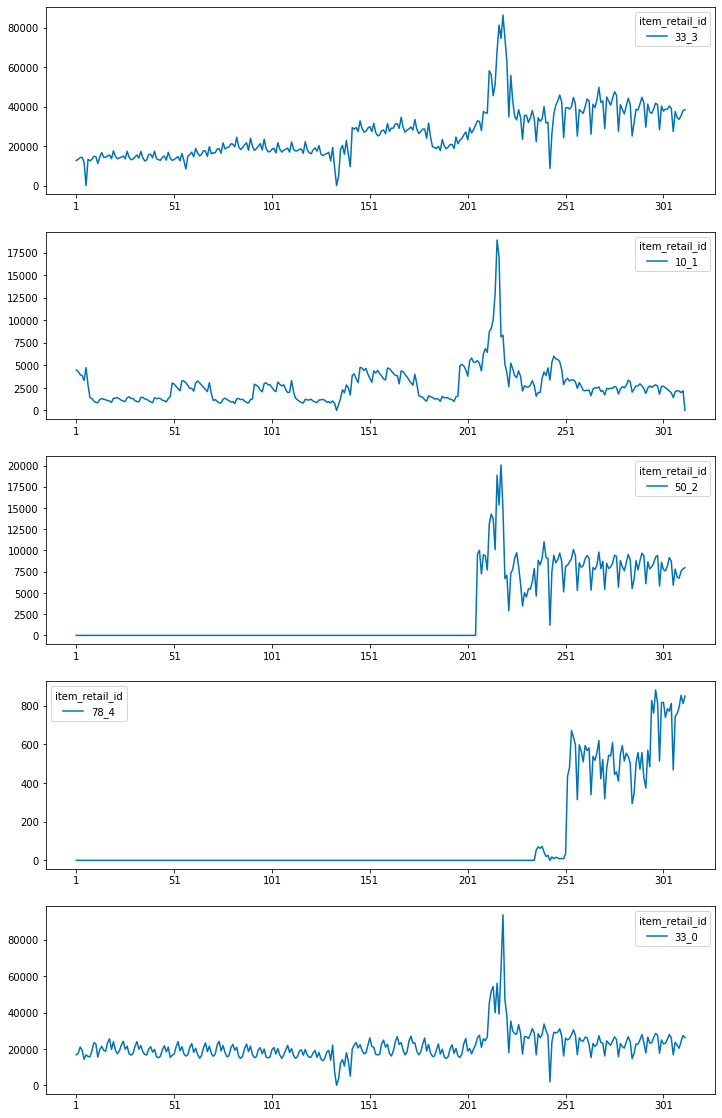

In [97]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
ids = df_unstacked["item_retail_id"].sample(n = 5, random_state = 1)
for i in range(len(ids)):
    series_ids(ids.iloc[i]).plot(ax = axes[i])

#### Note 
* We see some clear differences in the series shapes - there are visibly diffrent trends and time series shapes look different for the selected product-retailer combinations
* Plus the scale is different. The 4th  series has the most contrast , series 1,2,3 and 5 operating in the thousands a day and the former between 0 and 800 .
* Also, we see that some series only really "pick up" later after day 201 as on 3rd and 4th series, which is really interesting. Could this mean that this combination of zrep and retailer was not previously sold and seems to have been introduced thanks to the pandemic?

To avoid dealing with very noisy series, I'll bin sales by week, which will remove weekly seasonality and lead the number of sales per time unit to be less volitile.

In [98]:
"""
Time series for particular items are quite noisy on a daily level. 
Provide the ability to bin sales (for examply - to a weekly bin) for more stable plots
"""
def series_weekly(ids:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an id, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_ids(ids).reset_index()
    t["index"] = t.index.map(lambda x: x - (x % bin_every))
    t.columns = pd.Index(["day", "sales"])
    return t.groupby("day")\
        .agg({"sales":"sum"})

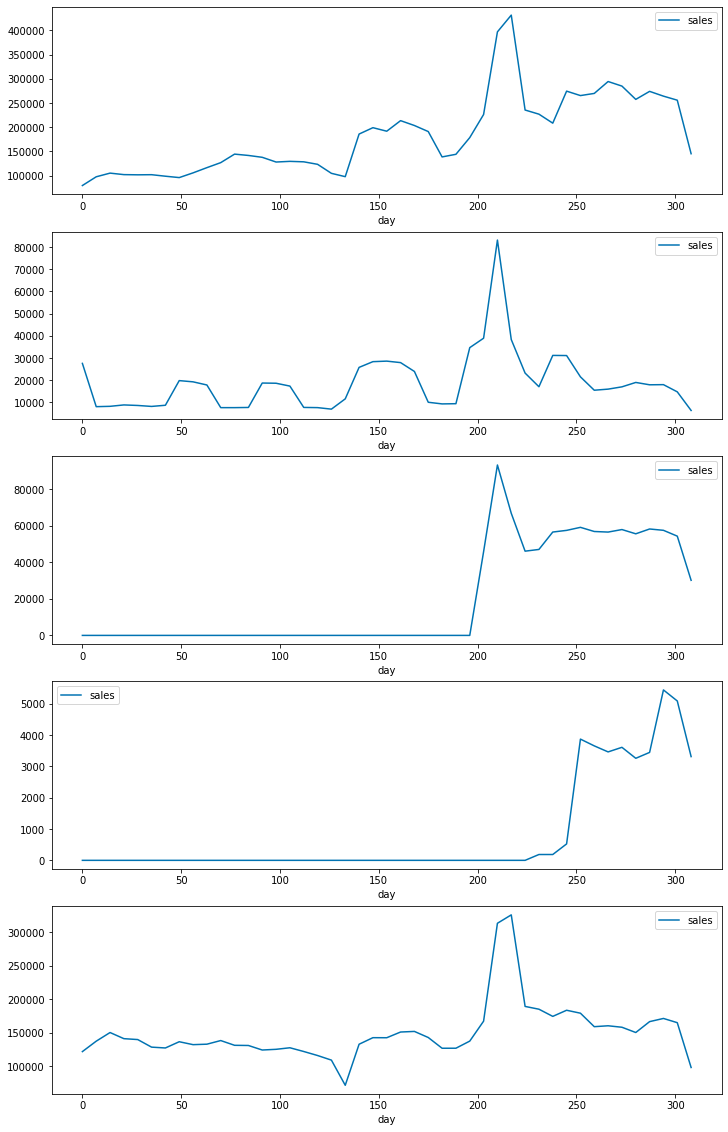

In [99]:
# bin the items by week and plot again
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
ids = df_unstacked["item_retail_id"].sample(n = 5, random_state = 1)
for i in range(len(ids)):
    series_weekly(ids.iloc[i], bin_every = 7).plot(ax = axes[i])

Now that we got rid of the weekly cycle, we see similarly to before that some sales only start after a certain day and that could be a complication that we might need to deal with outside of this analysis , for example introducing DMT (dynamic time wrapping) as a way of "clipping" the start of the series that had no sales before and only use the data after the sales "kicked in" and >0

In [100]:
# create a  lookup table for fast plotting by item
daily_sales_item_lookup = df_unstacked[["zrep"] + list(df_unstacked.columns[3:])]\
    .melt(id_vars = "zrep")\
    .groupby("zrep variable".split())\
    .agg({"value":"sum"})

def series_from_item(zrep:str) -> pd.DataFrame:
    return daily_sales_item_lookup.loc[zrep]

In [101]:
def series_weekly_zrep(zreps:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an item (across stores), grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_item(zreps).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

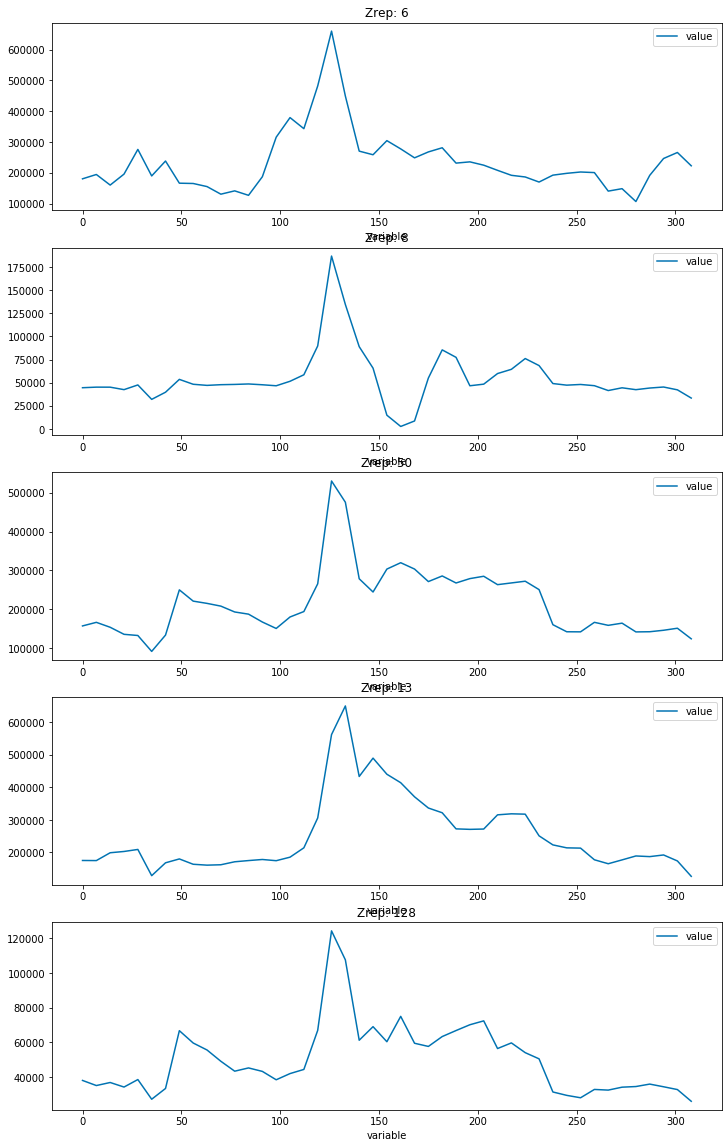

In [102]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(2)
zreps = sample(list(df_unstacked["zrep"].unique()), 5)
for i in range(len(zreps)):
    series_weekly_zrep(zreps[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Zrep: %s" % zreps[i])

When plotting 5 random zreps we do not see the same variability and later series start as we did with the zrep+retailer combination, as zrep is an identifier that is not tied to the retailer, it won't capture that a certain retailer did not have the product introduced until a certain day, whereas this is what we saw above with the zrep+retailer combination based plots

Finally , plotting on retailer level

In [103]:
# Create a  lookup table for fast plotting by retailer
daily_sales_retailer_lookup = df_unstacked[["retailer"] + list(df_unstacked.columns[3:])]\
    .melt(id_vars = "retailer")\
    .groupby("retailer variable".split())\
    .agg({"value":"sum"})
def series_from_ret(ret:str) -> pd.DataFrame:
    return daily_sales_retailer_lookup.loc[ret]

In [104]:
def series_weekly_ret(ret:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for a department, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_ret(ret).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

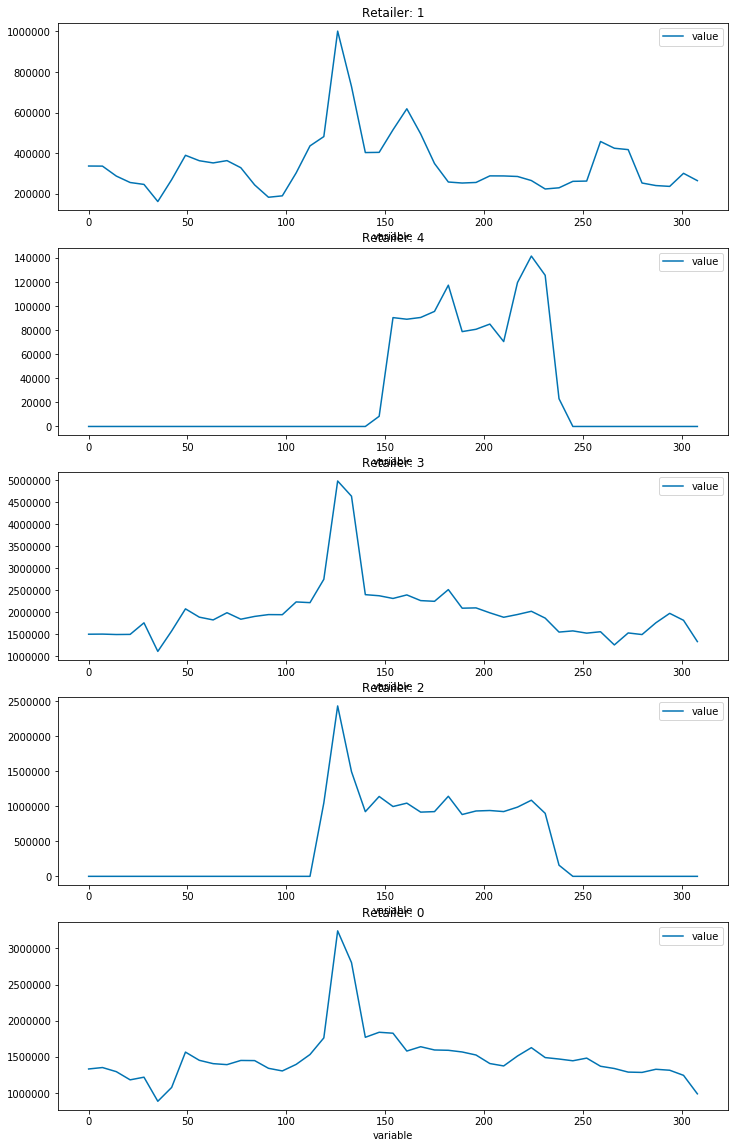

In [105]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(3)
retailers = sample(list(df_unstacked["retailer"].unique()), 5)
for i in range(len(retailers)):
    series_weekly_ret(retailers[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Retailer: %s" % retailers[i])

We see that for retailers 4 and 2 we actually do not capture any sales until after day 100. I wonder if this is the quirk of the data, as we would expect all the retailers to have data consistently for most days

#### Clustering on a item_retail_id (zrep+retailer) level

It probably makes sense to cluster on a level of series that doesn't have too much noise , but is stil useful.
I might settle on this level because retailer level is too broad and we only have a handful of them.

Clustering on levels lower than that would probably introduce too much noise. Although I acknowledge the fact that zrep/item+store combination might bring some extra level of information , I think zrep+retailer level could be a good way to start.

#### Standardisation
We are iltimately interested in the shape of the time -series, not clustering items that are in high demand vs those that are not, and because some of our items are more popular than others, we might want to "standardise" the series in a way

In [106]:
# create a global lookup table for fast plotting by item
daily_sales_itemretail_lookup = df_unstacked[["item_retail_id"] + list(df_unstacked.columns[3:])]\
    .melt(id_vars = "item_retail_id")\
    .groupby("item_retail_id variable".split())\
    .agg({"value":"sum"})

In [107]:
# create a global lookup table for fast plotting by item
daily_sales_item_lookup = df_unstacked[["zrep"] + list(df_unstacked.columns[3:])]\
    .melt(id_vars = "zrep")\
    .groupby("zrep variable".split())\
    .agg({"value":"sum"})

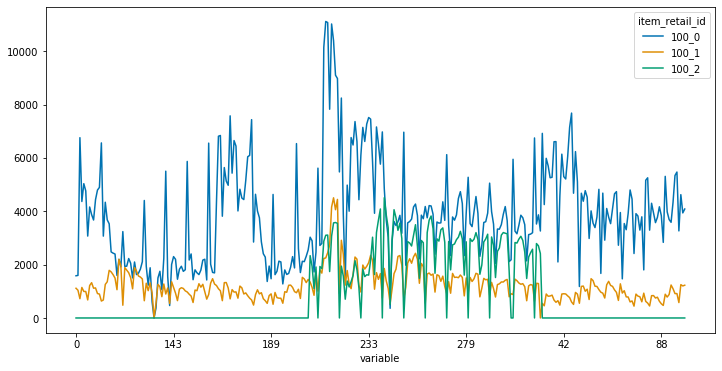

In [108]:
daily_sales_itemretail_lookup.pivot_table(index = "variable", columns = "item_retail_id", values = "value")\
    .iloc[:,:3]\
    .plot(figsize = (12,6))

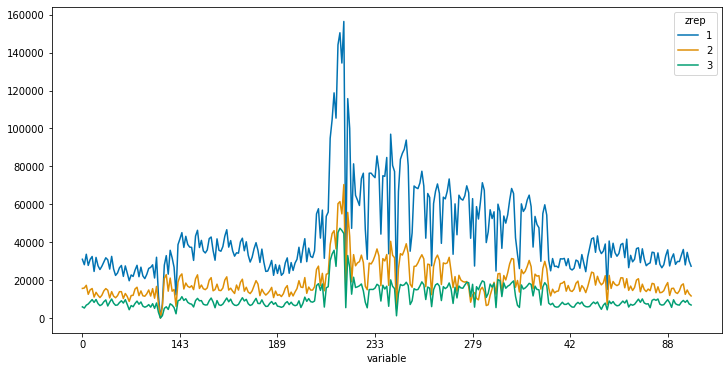

In [109]:
# plotting 10 series, for demonstration
daily_sales_item_lookup.pivot_table(index = "variable", columns = "zrep", values = "value")\
    .iloc[:,:3]\
    .plot(figsize = (12,6))

In [110]:
# Create a lookup table for scaled series
daily_sales_item_lookup_scaled = daily_sales_item_lookup\
    .pivot_table(index = "variable", columns = "zrep", values = "value").copy()
daily_sales_item_lookup_scaled = daily_sales_item_lookup_scaled.div(daily_sales_item_lookup_scaled.mean(axis = 0), axis = 1)

In [111]:
daily_sales_itemretail_lookup_scaled = daily_sales_itemretail_lookup\
    .pivot_table(index = "variable", columns = "item_retail_id", values = "value").copy()
daily_sales_itemretail_lookup_scaled = daily_sales_itemretail_lookup_scaled.div(daily_sales_itemretail_lookup_scaled.mean(axis = 0), axis = 1)

In [112]:
# bin by week
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled.copy().reset_index()

In [113]:
daily_sales_itemretail_lookup_scaled = daily_sales_itemretail_lookup_scaled.copy().reset_index()

In [114]:
daily_sales_item_lookup_scaled_weekly["variable"] = daily_sales_item_lookup_scaled_weekly.variable.index.map(lambda x: x - (x % 7))

In [115]:
daily_sales_itemretail_lookup_scaled["variable"] = daily_sales_itemretail_lookup_scaled.variable.index.map(lambda x: x - (x % 7))

In [116]:
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled_weekly.groupby("variable").mean()

In [117]:
daily_sales_itemretail_lookup_scaled = daily_sales_itemretail_lookup_scaled.groupby("variable").mean()

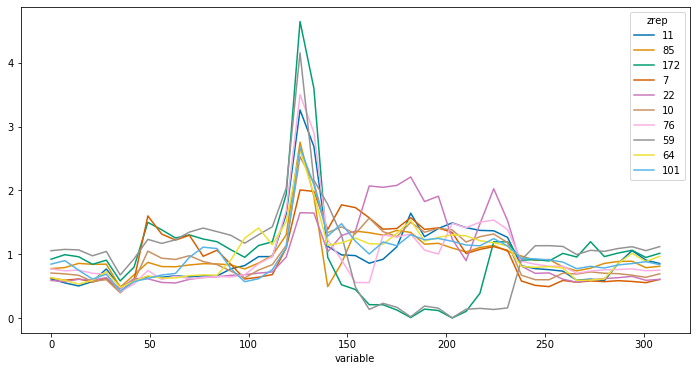

In [118]:
# plot those same series, but this time normalized by the series' means. 
random.seed(1)
daily_sales_item_lookup_scaled_weekly.iloc[:,random.sample(range(daily_sales_item_lookup_scaled_weekly.shape[1]),10)]\
    .plot(figsize = (12,6))

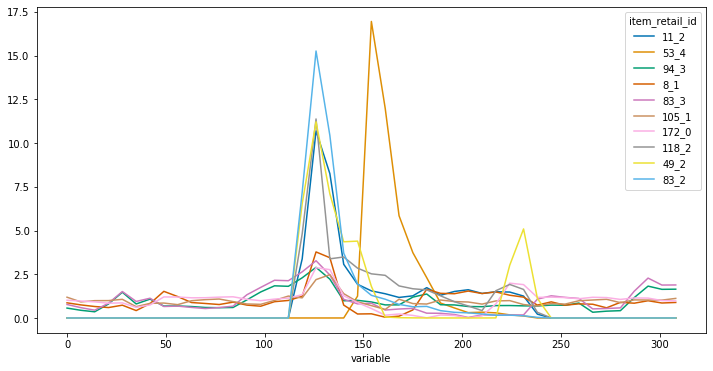

In [119]:
random.seed(1)
daily_sales_itemretail_lookup_scaled.iloc[:,random.sample(range(daily_sales_itemretail_lookup_scaled.shape[1]),10)]\
    .plot(figsize = (12,6))

Now that we have standerdised and brought the input data to the weekly level , we can focus on clustering based on series shape characteristics

#### Heirarchical clustering

The approach here that we will take first is called Hierarchical clustering, where each time-series would be viewed as a vector , all with same length , so we will be grouping series that behave in the similar way

In [137]:
# heirarchical clustering of scales weekly item sales. 
clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(daily_sales_itemretail_lookup_scaled.T.values)

In [138]:
def get_distances(X,model,mode='l2'):
    distances = []
    weights = []
    children=model.children_
    dims = (X.shape[1],1)
    distCache = {}
    weightCache = {}
    for childs in children:
        c1 = X[childs[0]].reshape(dims)
        c2 = X[childs[1]].reshape(dims)
        c1Dist = 0
        c1W = 1
        c2Dist = 0
        c2W = 1
        if childs[0] in distCache.keys():
            c1Dist = distCache[childs[0]]
            c1W = weightCache[childs[0]]
        if childs[1] in distCache.keys():
            c2Dist = distCache[childs[1]]
            c2W = weightCache[childs[1]]
        d = np.linalg.norm(c1-c2)
        cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

        X = np.vstack((X,cc.T))

        newChild_id = X.shape[0]-1

        # How to deal with a higher level cluster merge with lower distance:
        if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
            added_dist = (c1Dist**2+c2Dist**2)**0.5 
            dNew = (d**2 + added_dist**2)**0.5
        elif mode == 'max':  # If the previrous clusters had higher distance, use that one
            dNew = max(d,c1Dist,c2Dist)
        elif mode == 'actual':  # Plot the actual distance.
            dNew = d


        wNew = (c1W + c2W)
        distCache[newChild_id] = dNew
        weightCache[newChild_id] = wNew

        distances.append(dNew)
        weights.append( wNew)
    return distances, weights

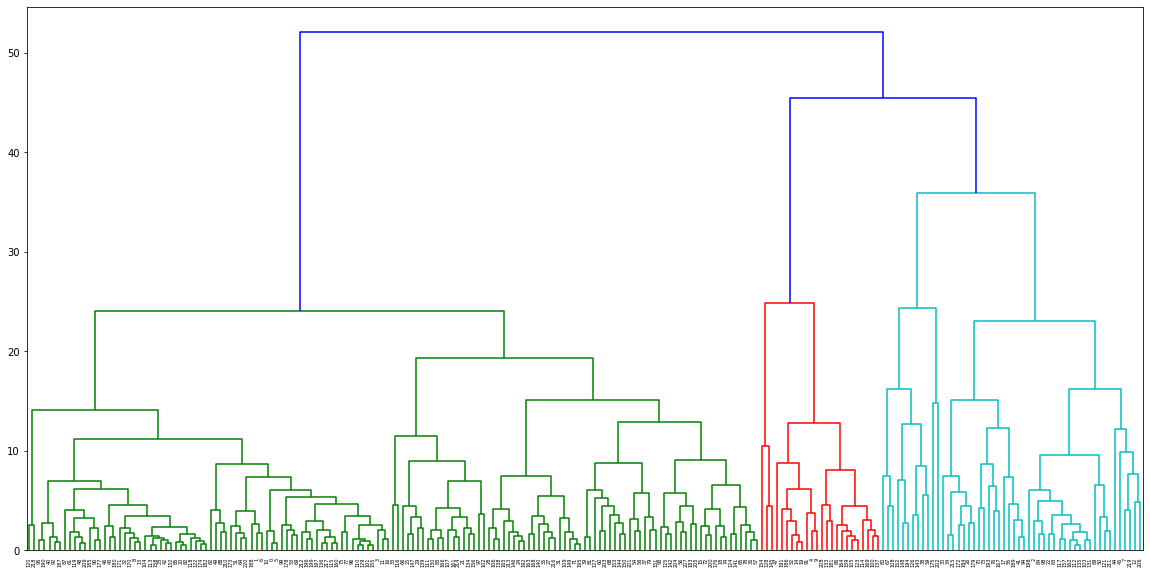

In [139]:
distance, weight = get_distances(daily_sales_itemretail_lookup_scaled.T.values,clf)
linkage_matrix = np.column_stack([clf.children_, distance, weight]).astype(float)
plt.figure(figsize=(20,10))
Z= dendrogram(linkage_matrix)
plt.show()

In [168]:
# extract clusters from dendogram
clusters = fcluster(linkage_matrix, 40, criterion='distance')
# create a lookup table for series in a given cluster
daily_sales_itemretail_lookup_scaled_clustered = daily_sales_itemretail_lookup_scaled.T.reset_index()
daily_sales_itemretail_lookup_scaled_clustered["cluster"] = clusters
daily_sales_itemretail_lookup_scaled_clustered = daily_sales_itemretail_lookup_scaled_clustered.set_index("cluster item_retail_id".split())\
    .sort_index()

In [169]:
daily_sales_itemretail_lookup_scaled_clustered

variable                     0         7         14        21        28        35        42        49        56        63        70        77        84        91        98        105       112       119        126        133       140       147        154        161       168       175       182       189       196       203       210       217       224       231       238       245       252       259       266       273       280       287       294       301       308
cluster item_retail_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1       100_0           0.997967  1.189788  0.805118  0.552835  0.473858  0.383201  0.517130  0.494796  0.631076  0.653410  1.133660  1.477189  1.413640  0.837223  0.547986  0.465924  0.707628  0.771324   2.364295   1.545512  1.533537  1.680984   1.394612   0.769781  1.038007  0.946835  0.938533  0.987902  1.050422  0.900037  0.935888  0.838619  0.989666  0.945439  1.346125  1.342378  1.398139  1.061736  0.931627  1.009061  0.877997  0.993119  0.987168  1.067834  1.099395
        100_1           0.786265  0.850277  1.167278  1.300715  1.273416  0.680128  0.831921  0.871693  0.747199  0.891462  0.947002  0.814506  0.754965  0.662713  0.619411  0.805328  0.947472  1.098089   2.354560   2.085804  1.256471  1.577002   1.166808   1.381907  1.520756  1.336016  1.219994  1.071260  1.105855  1.123270  0.966064  1.004895  1.031488  0.888167  0.517274  0.599642  0.600348  0.944413  0.861809  0.909347  0.613998  0.614939  0.566224  0.737786  0.851689
        100_3           0.830523  0.827673  0.788099  0.821972  0.938506  0.519301  0.751442  0.945666  0.908743  0.886470  1.033961  0.997967  1.026206  0.917626  0.793866  0.896811  0.985704  1.292750   2.385376   2.584837  1.186092  1.312305   1.503215   1.305544  1.037607  0.543894  0.230881  0.346687  1.066376  1.098990  1.046291  1.108071  1.165013  1.075259  0.841527  0.881167  0.841394  0.893099  0.787701  0.952957  0.908080  0.931745  0.956868  0.933933  0.876527
        101_0           1.043944  1.209367  0.826134  0.535938  0.489964  0.407904  0.523657  0.460075  0.605172  0.629301  1.176108  1.545429  1.485650  0.894716  0.531700  0.480616  0.707447  0.804614   2.824464   1.919205  1.390766  1.780085   1.350334   0.783855  0.957320  0.837003  0.803419  0.871348  0.910911  0.783529  0.837438  0.731467  0.905585  0.856023  1.284035  1.267841  1.293817  1.130786  0.975254  0.938843  0.900585  1.020576  1.100679  1.131546  1.077768
        101_1           0.766589  0.735078  1.067771  1.139885  1.760429  1.027169  1.074437  1.043531  0.882335  1.059893  1.059893  0.997475  0.863549  0.744167  0.641754  0.914453  1.115039  1.185941   2.665186   3.067570  1.602263  1.139279   0.865973   0.782951  1.254419  1.244117  1.054439  0.900515  0.913847  0.870821  0.826583  0.881123  0.897485  0.761741  0.422988  0.528432  0.561156  0.892637  0.821129  0.804767  0.561762  0.550248  0.487224  0.702960  0.802586
        101_3           0.848945  0.823460  0.783304  0.728585  0.844448  0.432290  0.656091  0.845518  0.857083  0.860831  0.920047  0.947032  0.976265  0.829885  0.723766  0.835881  0.913623  1.233583   2.247863   1.950496  1.074031  1.168263   1.039658   0.886531  1.046939  1.249431  1.782271  1.499789  1.210561  1.141921  1.062038  1.102943  1.156805  1.088594  0.794548  0.865864  0.798938  0.818427  0.737473  0.866721  0.882569  0.882033  0.865543  0.866292  0.793948
        104_0           1.026169  1.146664  0.882321  0.632107  0.561655  0.454898  0.688136  0.646531  0.772325  0.756331  0.970827  1.228596  1.212111  0.888699  0.691374  0.617683  

Plot samples of series from clusters
To get a feel for what this clustering method has actually produced, we can plot a sample of series from each cluster, and try and see what is in common between them.

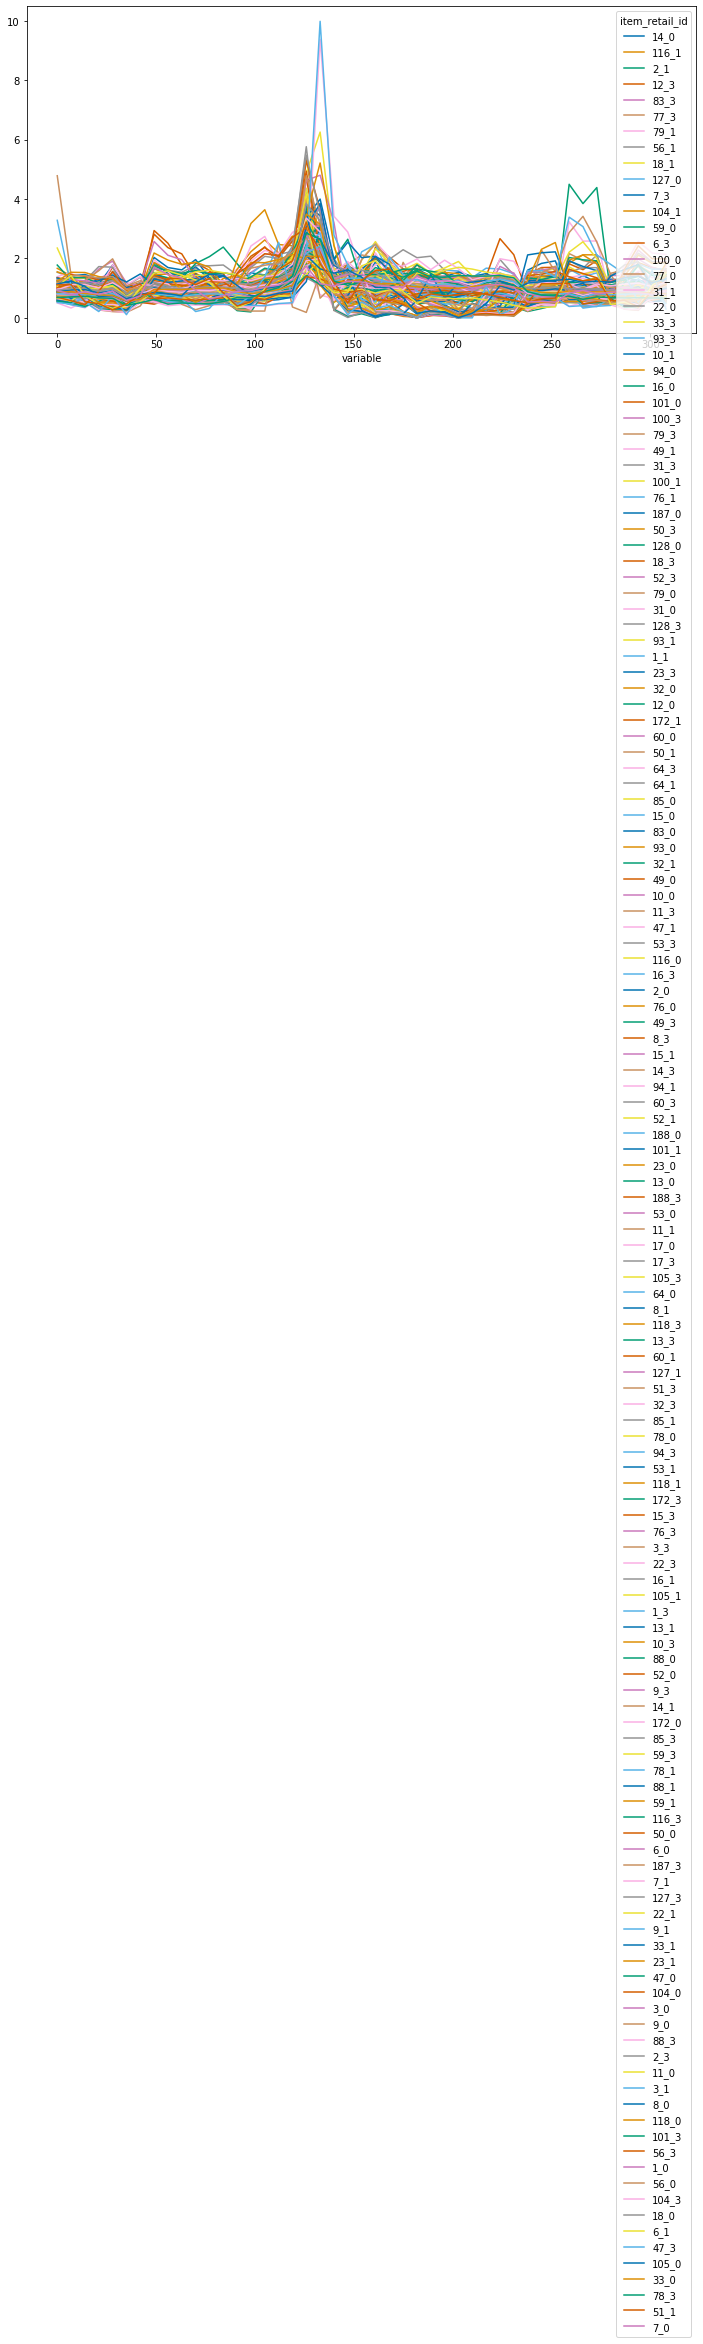

In [170]:
# cluster 1
random.seed(1)
daily_sales_itemretail_lookup_scaled_clustered.loc[1]\
    .T\
    .iloc[:, random.sample(range(daily_sales_itemretail_lookup_scaled_clustered.loc[1].shape[0]), daily_sales_itemretail_lookup_scaled_clustered.loc[1].shape[0])]\
    .plot(figsize = (12,6))

In [151]:
#add comment

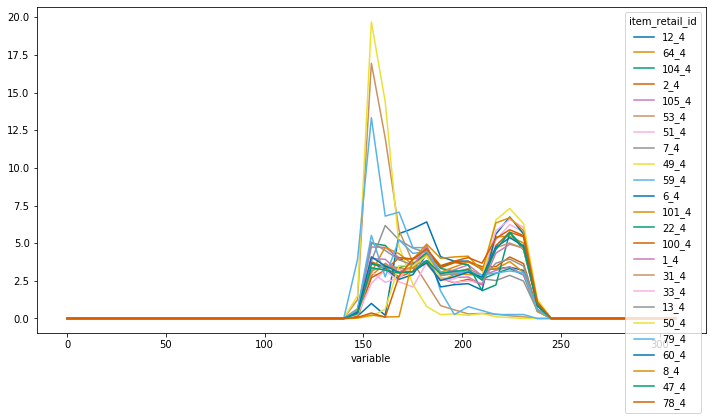

In [171]:
# series 2
random.seed(1)
daily_sales_itemretail_lookup_scaled_clustered.loc[2]\
    .T\
    .iloc[:, random.sample(range(daily_sales_itemretail_lookup_scaled_clustered.loc[2].shape[0]), daily_sales_itemretail_lookup_scaled_clustered.loc[2].shape[0])]\
    .plot(figsize = (12,6))

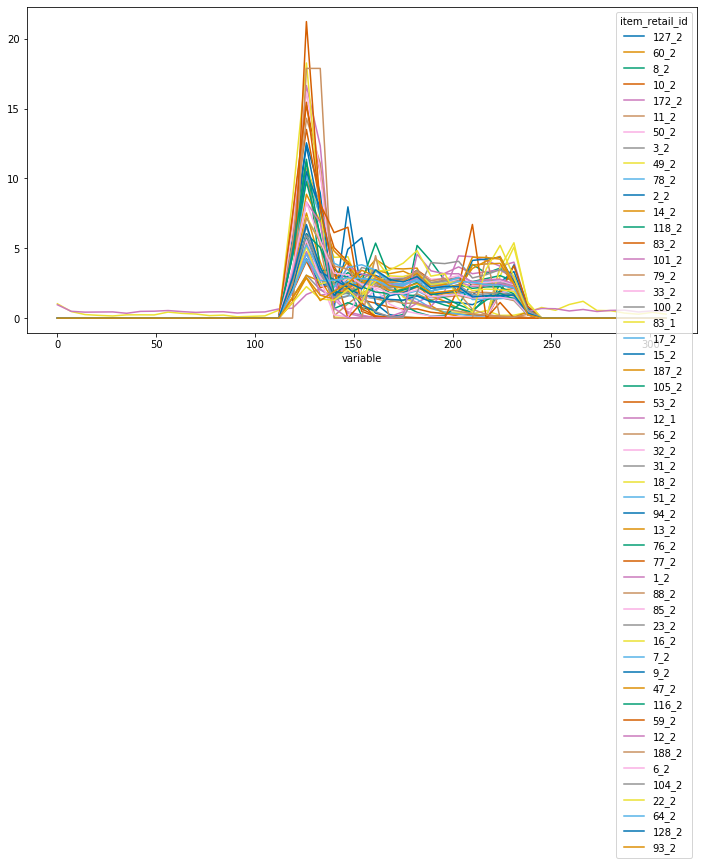

In [172]:
# cluster 3
random.seed(1)
daily_sales_itemretail_lookup_scaled_clustered.loc[3]\
    .T\
    .iloc[:, random.sample(range(daily_sales_itemretail_lookup_scaled_clustered.loc[3].shape[0]), daily_sales_itemretail_lookup_scaled_clustered.loc[3].shape[0])]\
    .plot(figsize = (12,6))

In [173]:
# cluster 4
# random.seed(1)
# daily_sales_itemretail_lookup_scaled_clustered.loc[4]\
#     .T\
#     .iloc[:, random.sample(range(daily_sales_itemretail_lookup_scaled_clustered.loc[4].shape[0]), daily_sales_itemretail_lookup_scaled_clustered.loc[4].shape[0])]\
#     .plot(figsize = (12,6))

In [174]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors.nearest_centroid import NearestCentroid

In [176]:
X = daily_sales_itemretail_lookup_scaled.T.values

In [179]:
clf = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_predict = clf.fit_predict(X)
cluster_labels = clf.labels_

In [187]:
daily_sales_itemretail_lookup_scaled.head(3)

item_retail_id,100_0,100_1,100_2,100_3,100_4,101_0,101_1,101_2,101_3,101_4,104_0,104_1,104_2,104_3,104_4,105_0,105_1,105_2,105_3,105_4,10_0,10_1,10_2,10_3,116_0,116_1,116_2,116_3,118_0,118_1,118_2,118_3,11_0,11_1,11_2,11_3,127_0,127_1,127_2,127_3,128_0,128_2,128_3,12_0,12_1,12_2,12_3,12_4,13_0,13_1,13_2,13_3,13_4,14_0,14_1,14_2,14_3,15_0,15_1,15_2,15_3,16_0,16_1,16_2,16_3,172_0,172_1,172_2,172_3,17_0,17_2,17_3,187_0,187_2,187_3,188_0,188_2,188_3,18_0,18_1,18_2,18_3,1_0,1_1,1_2,1_3,1_4,22_0,22_1,22_2,22_3,22_4,23_0,23_1,23_2,23_3,2_0,2_1,2_2,2_3,2_4,31_0,31_1,31_2,31_3,31_4,32_0,32_1,32_2,32_3,33_0,33_1,33_2,33_3,33_4,3_0,3_1,3_2,3_3,47_0,47_1,47_2,47_3,47_4,49_0,49_1,49_2,49_3,49_4,50_0,50_1,50_2,50_3,50_4,51_1,51_2,51_3,51_4,52_0,52_1,52_3,53_0,53_1,53_2,53_3,53_4,56_0,56_1,56_2,56_3,59_0,59_1,59_2,59_3,59_4,60_0,60_1,60_2,60_3,60_4,64_0,64_1,64_2,64_3,64_4,6_0,6_1,6_2,6_3,6_4,76_0,76_1,76_2,76_3,77_0,77_2,77_3,78_0,78_1,78_2,78_3,78_4,79_0,79_1,79_2,79_3,79_4,7_0,7_1,7_2,7_3,7_4,83_0,83_1,83_2,83_3,85_0,85_1,85_2,85_3,88_0,88_1,88_2,88_3,8_0,8_1,8_2,8_3,8_4,93_0,93_1,93_2,93_3,94_0,94_1,94_2,94_3,9_0,9_1,9_2,9_3
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.997967,0.786265,0.0,0.830523,0.0,1.043944,0.766589,0.0,0.848945,0.0,1.026169,0.867440,0.0,0.808332,0.0,1.138042,1.187070,0.0,1.025554,0.0,0.789219,1.034515,0.0,0.681338,1.128120,1.666150,0.0,0.556366,1.235746,1.549311,0.0,0.718153,0.784819,4.785933,0.0,0.575769,1.022753,0.653073,0.0,1.289943,0.917992,0.0,0.756727,0.661834,0.956401,0.0,0.692497,0.0,0.758046,0.585824,0.0,0.870445,0.0,0.909010,1.072454,0.0,1.078413,1.061719,1.049086,0.0,1.172770,0.848244,0.582314,0.0,0.895254,1.015426,0.545822,0.0,1.148583,0.944308,0.0,0.772320,1.352862,0.0,0.929934,1.121730,0.0,0.836237,0.929316,0.887415,0.0,0.978377,0.790367,0.960455,0.0,0.711699,0.0,0.739726,0.671852,0.0,0.643916,0.0,0.816534,1.248686,0.0,0.634265,0.827197,0.990971,0.0,0.832626,0.0,0.871765,1.250450,0.0,0.735261,0.0,1.054456,1.777092,0.0,0.792255,0.869076,1.232873,0.0,0.611582,0.0,0.851998,3.284699,0.0,0.745257,0.796060,0.502125,0.0,0.815066,0.0,0.984842,1.386838,0.0,0.848622,0.0,0.877262,1.279549,0.0,0.655192,0.0,1.110829,0.0,0.706563,0.0,1.118764,2.350430,0.665457,0.981325,1.332946,0.0,1.037940,0.0,1.171657,1.533496,0.0,0.697806,1.129676,1.036535,0.0,1.061945,0.0,0.847463,1.349555,0.0,0.611637,0.0,0.857900,1.157794,0.0,0.569900,0.0,1.116246,1.068562,0.0,0.598474,0.0,0.828454,1.257966,0.0,0.874641,0.795605,0.0,0.919045,0.701377,0.857293,0.0,0.683501,0.0,0.768685,0.933900,0.0,0.798883,0.0,0.920282,0.936109,0.0,0.607008,0.0,1.104233,1.024509,0.0,0.771154,0.850081,0.586507,0.0,0.887553,1.129392,1.156365,0.0,1.157394,0.876355,0.866661,0.0,0.887902,0.0,0.754079,0.599949,0.0,0.901902,0.963659,1.154589,0.0,0.565639,0.780543,0.515876,0.0,0.848181
7,1.189788,0.850277,0.0,0.827673,0.0,1.209367,0.735078,0.0,0.823460,0.0,1.146664,0.886712,0.0,0.805608,0.0,1.238667,0.918520,0.0,1.037625,0.0,0.723652,0.877985,0.0,0.764889,1.359111,1.410566,0.0,0.502469,1.533433,1.400059,0.0,0.651894,0.745750,1.412990,0.0,0.460328,1.041308,0.534854,0.0,1.171096,0.843727,0.0,0.700118,0.654468,0.487013,0.0,0.680766,0.0,0.791576,0.503953,0.0,0.875831,0.0,0.920975,0.709229,0.0,1.010749,1.088555,0.652676,0.0,1.145504,0.856641,0.499658,0.0,0.922442,0.967662,0.618776,0.0,1.356923,0.920897,0.0,0.608108,1.079849,0.0,1.082498,0.938936,0.0,0.934330,0.983930,0.940579,0.0,0.937087,0.763131,1.277829,0.0,0.654077,0.0,0.759590,0.565740,0.0,0.628944,0.0,0.742192,1.338812,0.0,0.609659,0.770518,1.277722,0.0,0.711038,0.0,0.831836,1.508548,0.0,0.823415,0.0,1.332890,1.263833,0.0,0.667138,0.876648,1.183780,0.0,0.688177,0.0,0.861037,1.059580,0.0,0.840219,0.813968,0.330411,0.0,0.789414,0.0,0.805356,1.538204,0.0,0.814428,0.0,0.893323,1.144779,0.0,0.757573,0.0,1.115648,0.0,0.672910,0.0,1.453654

In [186]:
10*22

220

In [181]:
y_predict

array([1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1,
       1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1,
       1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1,
       2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1], dtype=int64)

In [182]:
clf = NearestCentroid()
clf.fit(X, y_predict)
print("Centroids:")
print(clf.centroids_)

Centroids:
[[0.03809442 0.01842723 0.01306228 0.01216014 0.01149691 0.01108053
  0.01378939 0.01390185 0.01874245 0.01549477 0.01347846 0.01197745
  0.01291368 0.00876003 0.0103947  0.01159853 0.02354533 3.30268014
  8.38679201 5.27713147 2.20863859 2.42890483 1.93138921 2.08270888
  1.71578526 1.64484852 2.0707964  1.58102064 1.63359797 1.70680536
  1.74350207 1.8224141  2.25257848 2.055769   0.39411271 0.02785888
  0.02367562 0.02858831 0.03501549 0.01958341 0.020843   0.01790466
  0.01375689 0.01793539 0.0150224 ]
 [0.96977438 0.9104073  0.84846766 0.79972674 0.88676968 0.59453517
  0.81065694 1.08606136 0.99284198 0.93700412 0.95352158 0.94117826
  0.91928709 0.90084391 0.90914594 1.08520643 1.24336543 1.44228335
  2.77957053 2.32919698 1.18240288 1.05469119 1.03422648 0.95699143
  0.96371103 0.90722414 0.85518256 0.7849636  0.76603805 0.70195657
  0.70449177 0.79774451 0.8423727  0.78648192 0.85364204 0.9481104
  0.93956752 1.04097517 0.95635815 0.97187473 0.82506394 0.89452658
  

For n_clusters = 3 The average silhouette_score is : 0.5084094509913663


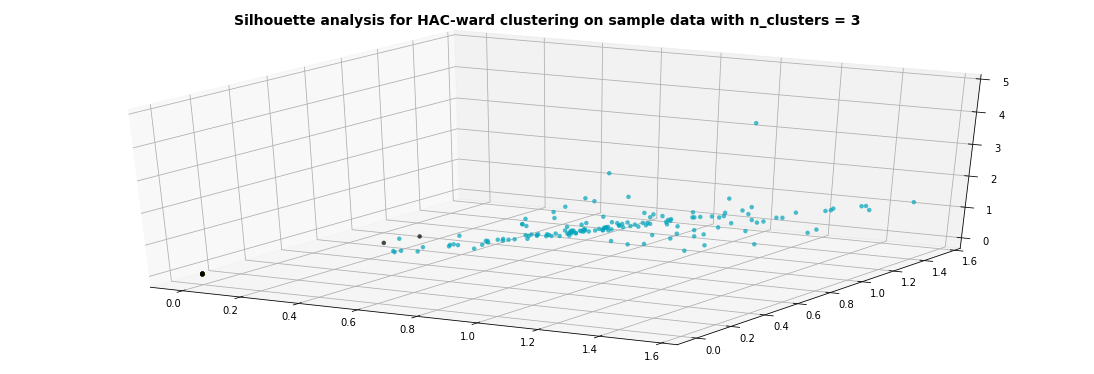

In [184]:
silhouette_avg = silhouette_score(X, cluster_labels)
if silhouette_avg > 0.4:
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax = Axes3D(fig)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(X[:, 1], X[:, 2], X[:, 0],marker='o', s=20, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    plt.suptitle(("Silhouette analysis for HAC-ward clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

#### Dynamic TIme Wrapping

You might notice that according to the clustering method above, two series that might look "similar" to the human eye might not be in the same clusters if they're not aligned. For example, consider the following two series:

In [144]:
daily_sales_itemretail_lookup_scaled.head(3)

item_retail_id,100_0,100_1,100_2,100_3,100_4,101_0,101_1,101_2,101_3,101_4,104_0,104_1,104_2,104_3,104_4,105_0,105_1,105_2,105_3,105_4,10_0,10_1,10_2,10_3,116_0,116_1,116_2,116_3,118_0,118_1,118_2,118_3,11_0,11_1,11_2,11_3,127_0,127_1,127_2,127_3,128_0,128_2,128_3,12_0,12_1,12_2,12_3,12_4,13_0,13_1,13_2,13_3,13_4,14_0,14_1,14_2,14_3,15_0,15_1,15_2,15_3,16_0,16_1,16_2,16_3,172_0,172_1,172_2,172_3,17_0,17_2,17_3,187_0,187_2,187_3,188_0,188_2,188_3,18_0,18_1,18_2,18_3,1_0,1_1,1_2,1_3,1_4,22_0,22_1,22_2,22_3,22_4,23_0,23_1,23_2,23_3,2_0,2_1,2_2,2_3,2_4,31_0,31_1,31_2,31_3,31_4,32_0,32_1,32_2,32_3,33_0,33_1,33_2,33_3,33_4,3_0,3_1,3_2,3_3,47_0,47_1,47_2,47_3,47_4,49_0,49_1,49_2,49_3,49_4,50_0,50_1,50_2,50_3,50_4,51_1,51_2,51_3,51_4,52_0,52_1,52_3,53_0,53_1,53_2,53_3,53_4,56_0,56_1,56_2,56_3,59_0,59_1,59_2,59_3,59_4,60_0,60_1,60_2,60_3,60_4,64_0,64_1,64_2,64_3,64_4,6_0,6_1,6_2,6_3,6_4,76_0,76_1,76_2,76_3,77_0,77_2,77_3,78_0,78_1,78_2,78_3,78_4,79_0,79_1,79_2,79_3,79_4,7_0,7_1,7_2,7_3,7_4,83_0,83_1,83_2,83_3,85_0,85_1,85_2,85_3,88_0,88_1,88_2,88_3,8_0,8_1,8_2,8_3,8_4,93_0,93_1,93_2,93_3,94_0,94_1,94_2,94_3,9_0,9_1,9_2,9_3
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.997967,0.786265,0.0,0.830523,0.0,1.043944,0.766589,0.0,0.848945,0.0,1.026169,0.867440,0.0,0.808332,0.0,1.138042,1.187070,0.0,1.025554,0.0,0.789219,1.034515,0.0,0.681338,1.128120,1.666150,0.0,0.556366,1.235746,1.549311,0.0,0.718153,0.784819,4.785933,0.0,0.575769,1.022753,0.653073,0.0,1.289943,0.917992,0.0,0.756727,0.661834,0.956401,0.0,0.692497,0.0,0.758046,0.585824,0.0,0.870445,0.0,0.909010,1.072454,0.0,1.078413,1.061719,1.049086,0.0,1.172770,0.848244,0.582314,0.0,0.895254,1.015426,0.545822,0.0,1.148583,0.944308,0.0,0.772320,1.352862,0.0,0.929934,1.121730,0.0,0.836237,0.929316,0.887415,0.0,0.978377,0.790367,0.960455,0.0,0.711699,0.0,0.739726,0.671852,0.0,0.643916,0.0,0.816534,1.248686,0.0,0.634265,0.827197,0.990971,0.0,0.832626,0.0,0.871765,1.250450,0.0,0.735261,0.0,1.054456,1.777092,0.0,0.792255,0.869076,1.232873,0.0,0.611582,0.0,0.851998,3.284699,0.0,0.745257,0.796060,0.502125,0.0,0.815066,0.0,0.984842,1.386838,0.0,0.848622,0.0,0.877262,1.279549,0.0,0.655192,0.0,1.110829,0.0,0.706563,0.0,1.118764,2.350430,0.665457,0.981325,1.332946,0.0,1.037940,0.0,1.171657,1.533496,0.0,0.697806,1.129676,1.036535,0.0,1.061945,0.0,0.847463,1.349555,0.0,0.611637,0.0,0.857900,1.157794,0.0,0.569900,0.0,1.116246,1.068562,0.0,0.598474,0.0,0.828454,1.257966,0.0,0.874641,0.795605,0.0,0.919045,0.701377,0.857293,0.0,0.683501,0.0,0.768685,0.933900,0.0,0.798883,0.0,0.920282,0.936109,0.0,0.607008,0.0,1.104233,1.024509,0.0,0.771154,0.850081,0.586507,0.0,0.887553,1.129392,1.156365,0.0,1.157394,0.876355,0.866661,0.0,0.887902,0.0,0.754079,0.599949,0.0,0.901902,0.963659,1.154589,0.0,0.565639,0.780543,0.515876,0.0,0.848181
7,1.189788,0.850277,0.0,0.827673,0.0,1.209367,0.735078,0.0,0.823460,0.0,1.146664,0.886712,0.0,0.805608,0.0,1.238667,0.918520,0.0,1.037625,0.0,0.723652,0.877985,0.0,0.764889,1.359111,1.410566,0.0,0.502469,1.533433,1.400059,0.0,0.651894,0.745750,1.412990,0.0,0.460328,1.041308,0.534854,0.0,1.171096,0.843727,0.0,0.700118,0.654468,0.487013,0.0,0.680766,0.0,0.791576,0.503953,0.0,0.875831,0.0,0.920975,0.709229,0.0,1.010749,1.088555,0.652676,0.0,1.145504,0.856641,0.499658,0.0,0.922442,0.967662,0.618776,0.0,1.356923,0.920897,0.0,0.608108,1.079849,0.0,1.082498,0.938936,0.0,0.934330,0.983930,0.940579,0.0,0.937087,0.763131,1.277829,0.0,0.654077,0.0,0.759590,0.565740,0.0,0.628944,0.0,0.742192,1.338812,0.0,0.609659,0.770518,1.277722,0.0,0.711038,0.0,0.831836,1.508548,0.0,0.823415,0.0,1.332890,1.263833,0.0,0.667138,0.876648,1.183780,0.0,0.688177,0.0,0.861037,1.059580,0.0,0.840219,0.813968,0.330411,0.0,0.789414,0.0,0.805356,1.538204,0.0,0.814428,0.0,0.893323,1.144779,0.0,0.757573,0.0,1.115648,0.0,0.672910,0.0,1.453654

Text(0.5, 0, 'Days since start')

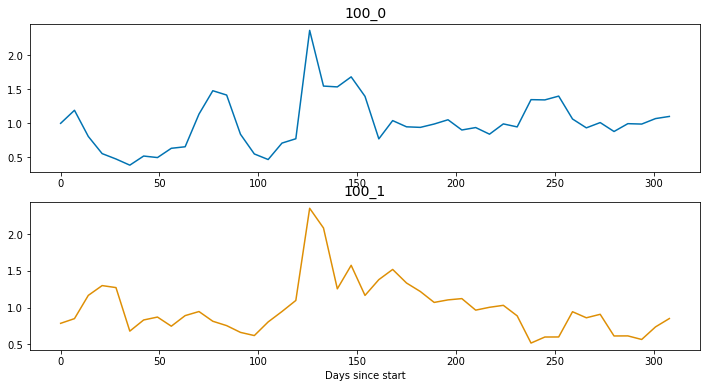

In [145]:
fig, [ax1,ax2] = plt.subplots(nrows = 2, figsize = (12,6))
daily_sales_itemretail_lookup_scaled["100_0"].plot(ax = ax1, color = "C0")
daily_sales_itemretail_lookup_scaled["100_1"].plot(ax = ax2, color = "C1")
ax1.set_title("100_0", fontsize= 14)
ax2.set_title("100_1", fontsize= 14)
ax1.set_xlabel("")
ax2.set_xlabel("Days since start")

if you were to describe why these to series are alike you might say: "They both start with zero sales, and then steady sales start."

Heirarchical clustering is blind to these types of similarities, however, as it measures the similarity between vectors element-wise - for example using Euclidean distance. Thus, even two identical series might not be recognized as similar if they're shifted from one another.

To address this, I use a method for comparing misaligned time series called Dynamic Time Warping. This dynamic programming algorithm allows for elements in one series to be compared to elements in another series that are either forward or backwards in time. This allows for two series to be recognized as similar in shape, even if they're not aligned.

In this section, I demonstrate how one might use this method or a similar method to better group time series which share the same overall shape.

In [165]:
# to do , edit above and add more info on DTW

#### Dynamic Time Warping distance: example
To get an intuition for how dynamic time warping (DTW) works, it's best to see an example. Using the two series from above:

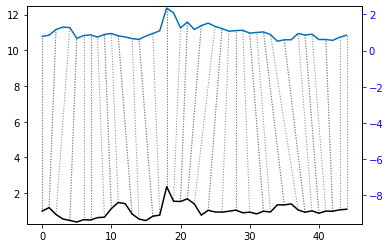

In [148]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(
     daily_sales_itemretail_lookup_scaled["100_0"],\
    daily_sales_itemretail_lookup_scaled["100_1"],\
    keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(3, "c"))\
    .plot(type="twoway",offset=10)

In [167]:
#The chart above plots the two series, and uses dotted lines to indicate which points in time are compared betwen the two series.

#You can see that the by looking forward/backwards in time, the flat parts of the series are compared, and the sections of the series that have positive sales are compared. This way, the two series aren't found to be dissimilar just because they start at a different time point.

#### Clustering using DTW
Now I'll use the same hierarchical clustering method, but instead of using Euclidean distance to compare series, I'll use normalized DTW distance.

The DTW algorithm time complexity is quadratic in the size of each vector. If there are  m  items in the dataset, each of them with  n  elements, then the time to compute a full distance matrix between the series in this dataset is  O(m2n2) , which would take a long time for a dataset of this size. To speed up this demonstration, I'll only use a sample of the items in this dataset.

In [149]:
def get_dtw_diff_matrix(cols:list):
    """
    From a list of series, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = daily_sales_itemretail_lookup_scaled[col1]
        series2 = daily_sales_itemretail_lookup_scaled[col2]
        diff = dtw(
            series1, 
            series2,
            keep_internals=True, 
            step_pattern=rabinerJuangStepPattern(2, "c")
            )\
            .normalizedDistance
        diff_matrix[(col1, col2)] = [diff]
    return diff_matrix

In [150]:
# sample 50 series, and compute the DTW distance matrix
random.seed(1)
sample_cols = random.sample(list(daily_sales_itemretail_lookup_scaled.columns), 50)
dtw_diff_dict = get_dtw_diff_matrix(sample_cols)
# make into a df
dtw_diff_df = pd.DataFrame(dtw_diff_dict).T.reset_index()\
    .rename(columns = {"level_0":"item1", "level_1":"item2", 0:"diff"})\
    .pivot_table(index = "item1", columns = "item2", values = "diff")

In [151]:
dtw_diff_df.head(3)

item2,100_0,100_2,101_0,101_1,101_2,105_1,116_0,116_2,118_2,11_2,14_0,14_2,14_3,15_1,15_2,172_0,172_3,18_3,2_1,2_3,32_2,33_0,33_2,33_4,3_0,47_1,49_0,49_2,51_2,52_0,53_0,53_4,59_1,60_0,6_1,77_2,78_1,79_2,7_0,83_2,83_3,85_0,88_1,88_2,8_1,8_3,8_4,93_3,94_3,9_1
item1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100_0,0.000000,0.931622,0.058379,0.256465,0.840688,0.180325,0.291317,0.756812,0.730654,0.745972,0.212362,0.830997,0.252229,0.309945,0.987627,0.300222,0.440881,0.376746,0.293790,0.163728,0.925430,0.171335,0.934310,0.971528,0.170074,0.286610,0.288798,1.055595,0.942206,0.346548,0.267012,1.015112,0.344163,0.161650,0.246923,0.952984,0.222691,0.849362,0.190481,0.943882,0.353158,0.192584,0.411476,1.293012,0.268366,0.234645,1.056085,0.208706,0.284245,0.300911
100_2,0.895467,0.000000,0.853483,0.889498,0.201972,0.989188,0.853993,0.405544,0.369262,0.535283,0.863923,0.288820,0.970908,0.938516,0.701333,0.961268,1.021914,1.042740,0.882003,0.863268,0.740858,0.979176,0.118422,0.259197,0.953698,0.736830,1.024979,0.770127,0.115641,0.739552,0.958593,0.779231,0.960617,0.991425,0.770659,0.736399,0.951263,0.367278,0.966307,0.782232,0.688530,0.981371,1.027904,1.091543,0.896363,0.870296,0.577889,0.885598,0.724821,0.781102
101_0,0.064633,0.897722,0.000000,0.268317,0.876037,0.179745,0.295591,0.764320,0.726468,0.768744,0.222698,0.826479,0.284659,0.318961,0.960504,0.281752,0.428426,0.377200,0.307068,0.196678,0.919114,0.200629,0.915770,0.957462,0.180678,0.277576,0.294448,1.025066,0.923649,0.344510,0.270364,0.977750,0.323359,0.189237,0.234520,0.920407,0.215097,0.883061,0.231254,0.916467,0.345226,0.219500,0.408430,1.272422,0.278405,0.263466,1.025756,0.212812,0.299913,0.274977


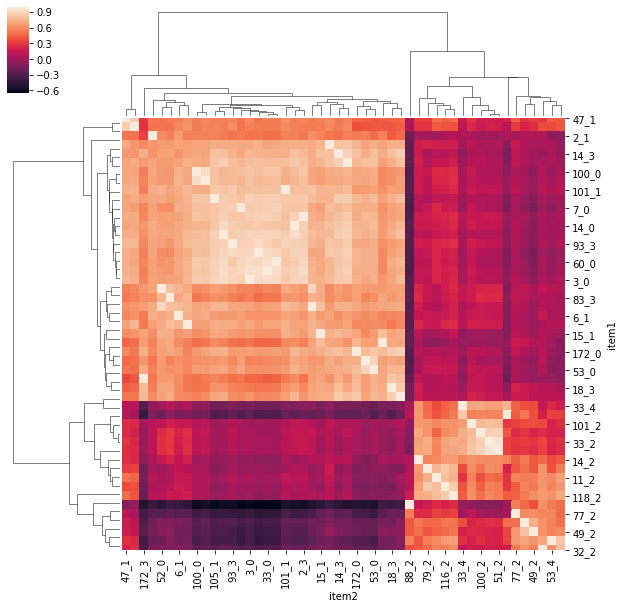

In [152]:
# plot a similarity matrix, with a dendogram imposed
import seaborn as sns
sns.clustermap(1-dtw_diff_df)

##### Extract clusters
Using this DTW distance matrix, we can perform heirarchical clustering and extract the clusters formed using this new distance function.

In [154]:
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

In [155]:
# ward clustering from difference matrix, where distance is Dynamic time warping distance instead of Euclidean
t = ward(dtw_diff_df)
# extract clusters
dtw_clusters = pd.DataFrame({"cluster":fcluster(t, 1.15)}, index = dtw_diff_df.index)

Text(0.5, 1.0, 'Frequency of DTW clusters')

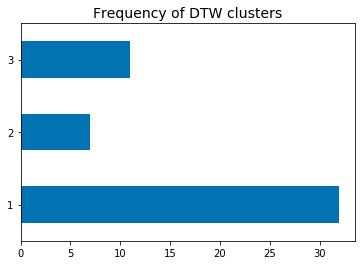

In [156]:
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title("Frequency of DTW clusters", fontsize = 14)

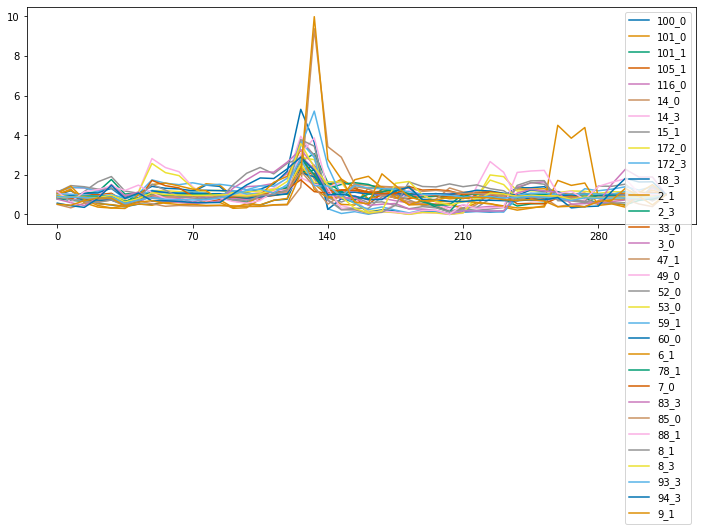

In [158]:
# cluster 1
daily_sales_itemretail_lookup_scaled.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster == 1], 
    left_index = True,
    right_index = True
)\
    .T\
    .plot(figsize = (12,4))

In [176]:
#We can see that what the series in this cluster have in common is that they have intermittent of no sales, followed by periods of stable sales.

#Showing the series pair-wise makes this clearer:

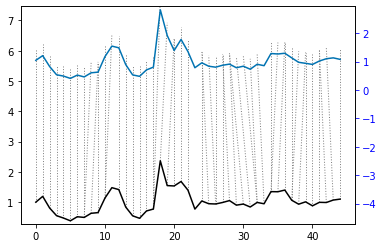

In [161]:
def plot_dtw(series1:str, series2:str) -> None:
    dtw(daily_sales_itemretail_lookup_scaled[series1],\
            daily_sales_itemretail_lookup_scaled[series2],\
        keep_internals=True, 
        step_pattern=rabinerJuangStepPattern(2, "c"))\
        .plot(type="twoway",offset=5)

plot_dtw("100_0", "101_0")


You can see that the periods of no sales are aligned betwen the two series, and the periods with stable sales are aligned. According to to DTW distance function, the series above are shown to be similar, though if we compared them element-wise we would not be able to detect this.

In [177]:
#We can repeat this for another cluster:

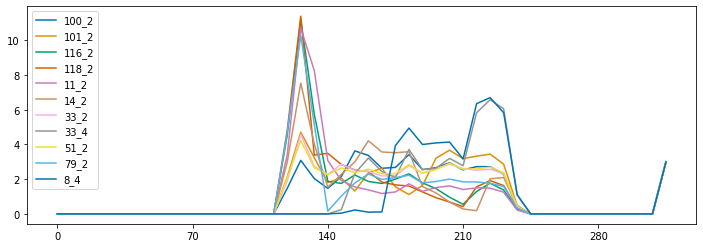

In [164]:
# cluster 3
daily_sales_itemretail_lookup_scaled.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster == 3], 
    left_index = True,
    right_index = True
)\
    .T\
    .plot(figsize = (12,4))

These series are similar in that they all start with few sales, and then experience a period of increasing sales. Seeing the DTW alignment:

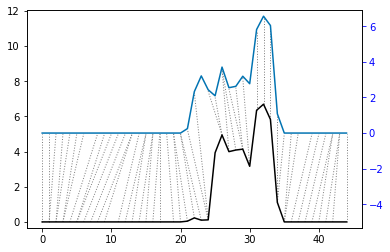

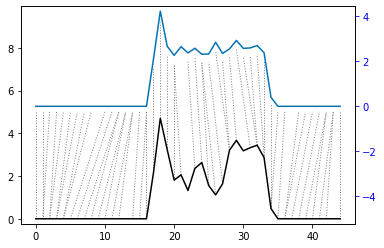

In [165]:
# see which items are in cluster 5
plot_dtw("8_4", "33_4")
plot_dtw("101_2", "51_2")



#### Conclusion and Next steps
* In this notebook, I showed two methods one could use to cluster time series: heirarchical clustering using Euclidean distance and clustering using DTW distance.

* As a follow up, I'd like to demonstrate how one could use these methods to improve modeling performance. For example: instead of training a model on the entire dataset, it may make sense to train one model per cluster, as the underlying structure of the series' are similar within a cluster. Or, one could pre-process (scaling, clipping) the series within a cluster in a similar way.

In [180]:
#to do list
#add helper functions file and put all functions there - 4 (2/08)
#connect notebook to github - 6 (2/08)
# link cluster elements with /brand/subbrand, get centroids, prediction- expand the comments (2/08)
# research how we deployed an app with heroku /flask -deploy an app OR write medium article -7 (2-3/08)